# Project: TMDb movie data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Overview**：
>
> This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.
> 
> Certain columns, like ‘cast’ and ‘genres’, contain multiple values separated by pipe `(|)` characters.
> There are some odd characters in the ‘cast’ column. Don’t worry about cleaning them. You can leave them as is.
> The final two columns ending with “_adj” show the budget and revenue of the associated movie in terms of 2010 dollars, accounting for inflation over time.
> 
> **Example Questions**: 
> - Which genres are most popular from year to year? 
> - What kinds of properties are associated with movies that have high revenues?
>
> **Purpose**:
> 
> In this report, I will explore the correlation between revenue and other metrics in order to understand the performance of directors and casts.

Import the packages

In [217]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns #visualization tool
from wordcloud import WordCloud
import collections
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

Check the data, datatypes, and make sure the data is not null.

In [442]:
# Load the data and find out the datatypes and whether the metrics are null.
df = pd.read_csv('tmdb-movies.csv')
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [6]:
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In [444]:
# check the size of dataset.
df.shape

(10866, 21)

It seems that columns `homepage`, `tagline`, `overview` can be dropped.

### Data Cleaning
#### Step 1: Drop columns that are not related to my analysis.
Drop three columns: `homepage`, `tagline`, `overview`: 

In [7]:
# Drop columns
df.drop(['homepage', 'tagline', 'keywords', 'overview'], axis=1, inplace=True)

In [8]:
# confirm changes
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


#### Step 2: Check nulls and drop rows that are null.

In [9]:
# View missing counts for each feature in the data
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
director                  44
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [10]:
# Drop the column `imdb_id` since we already have id.
df.drop(['imdb_id'], axis=1, inplace=True)
df.isnull().sum()

id                         0
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
director                  44
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [11]:
# Drop the rows where the column `genres` has null cells, since genres is a key metric that we need to explore.
df.dropna(subset=['genres'], inplace=True)
df.isnull().sum()

id                         0
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      75
director                  42
runtime                    0
genres                     0
production_companies    1016
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [12]:
# Drop the rows where the columns `cast`, `director`, and `production_companies` has null cells.
df.dropna(subset=['cast', 'director', 'production_companies'], inplace=True)
df.isnull().sum()

id                      0
popularity              0
budget                  0
revenue                 0
original_title          0
cast                    0
director                0
runtime                 0
genres                  0
production_companies    0
release_date            0
vote_count              0
vote_average            0
release_year            0
budget_adj              0
revenue_adj             0
dtype: int64

In [13]:
df.shape # finally, the not null dataset has 9773 rows and 16 columns.

(9773, 16)

#### Step 3: Check and drop the duplicated data.

In [14]:
# check the duplicated row.
df.duplicated().sum()

1

In [15]:
# drop the duplicated row.
df.drop_duplicates(inplace=True)

In [16]:
# check the number of rows.
df.shape

(9772, 16)

In [17]:
# save to a new csv file
df.to_csv('imbd_clean.csv')

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: Which <font color='red'>genres</font> are most popular from year to year? 

#### Step 1: Find out the most popular genres from year to year.

In [119]:
# count the genre frequency over years.
list1 = [] # list of genre for each movie
for i in df.genres:
    temp_genre = i.split('|')
    for j in temp_genre:
        list1.append(j)

In [170]:
# count the frequency of each genre:
counter = collections.Counter(list1)

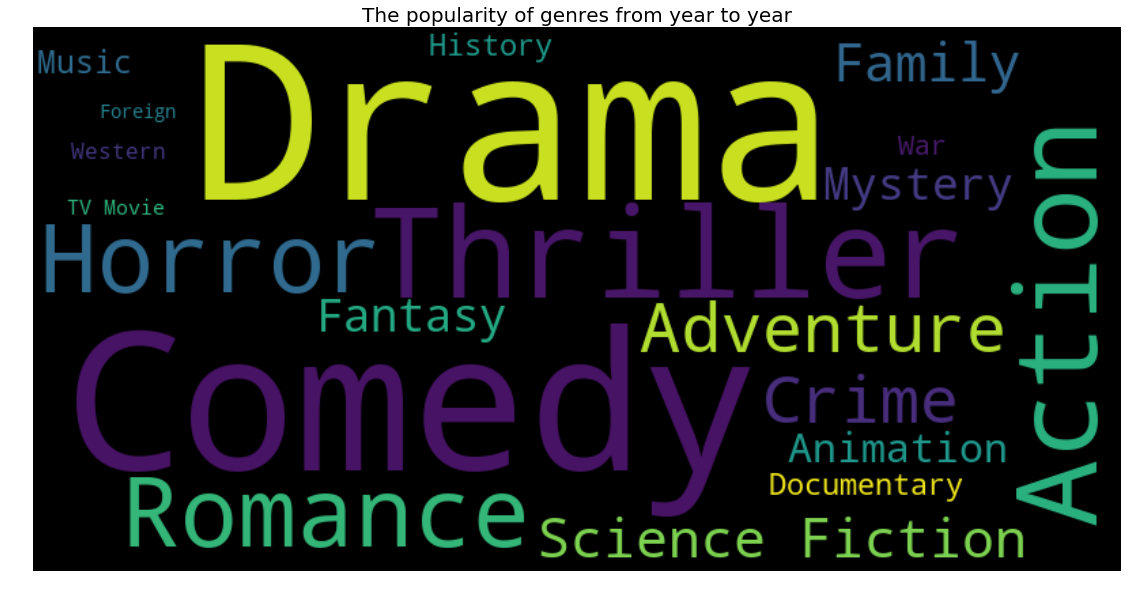

In [165]:
# visualize the most popular genres.
wordcloud = WordCloud(width=800, height=400)

wordcloud.generate_from_frequencies(frequencies=counter)
plt.figure(figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('The popularity of genres from year to year', fontsize=20)
plt.show()

This chart shows that `Drama`, `Thriller`, and `Comeday` are two most popular genres from year to year.

In [181]:
# calculate the market share of each genre:
total_popularity = sum(counter.values())
genres_percentage = []

for i in counter.values():
    genres_percentage.append(i/total_popularity)

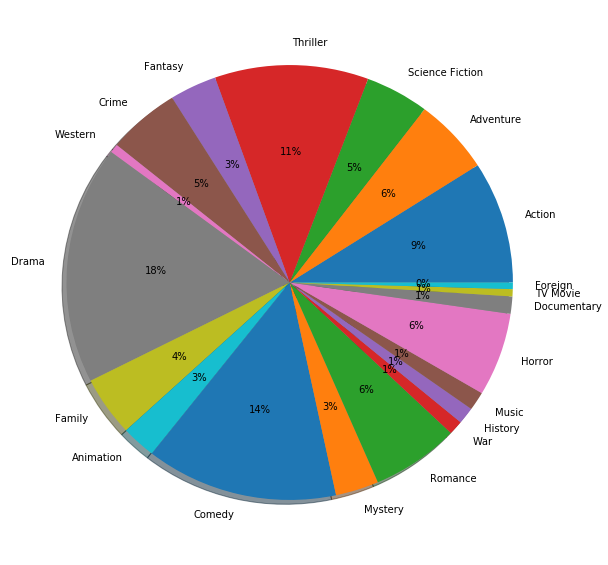

In [193]:
# visualize the percentage of popularity using pie chart:
plt.subplots(figsize=(10, 10))
plt.pie(genres_percentage, labels=counter.keys(), autopct='%1.0f%%', shadow=True);

This chart shows that `Drama` is <font color='blue'>18%</font> share and `Comeday` is <font color='blue'>14%</font> share.

#### Step 2: Find out the most popular genres during each year.

In [64]:
# load the cleaned data.
df_clean = pd.read_csv('imbd_clean.csv')
df_clean.head(1)

,Unnamed: 0,id,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In [116]:
# count the genre frequency w.r.t each year.
list2 = {} # list of genre for each movie
for i in sorted(df_clean.release_year):
    list2[i] = []

In [117]:
# assign the genres to each 'release_year' key.
for i in df_clean.index:
    list2[df_clean['release_year'].loc[i]] += df_clean['genres'].loc[i].split('|') # data structure: {release_year: [genres]}

In [168]:
# count the frequency of each genre during each year:
counter_release_year = {}
for ry in list2.keys():
    counter_release_year[ry]=collections.Counter(list2[ry])

In [161]:
# find the frequency of each genre during 2015:
sorted_key = []
sorted_freq = []

sorted_d = sorted((value, key) for (key,value) in counter_release_year[2015].items())
for i in sorted_d:
    sorted_key.append(i[1])
    sorted_freq.append(i[0])

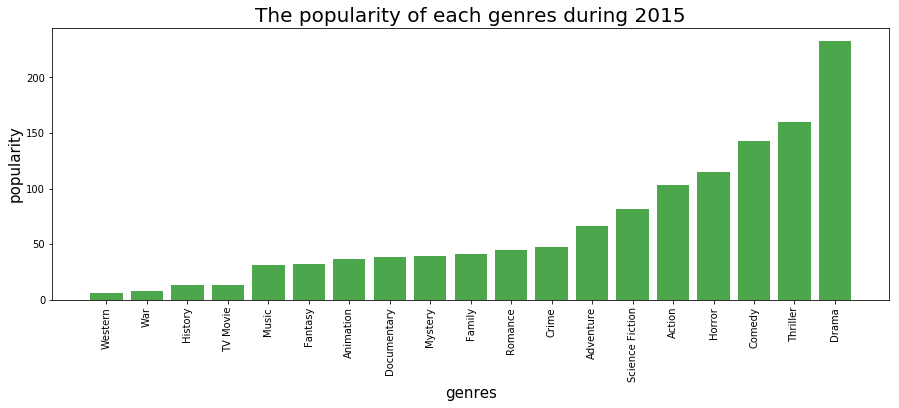

In [167]:
# visualize the popularity of each genre during this year
plt.subplots(figsize=(15, 5))
plt.bar(sorted_key, sorted_freq, color='g', alpha=.7)
plt.xticks(rotation=90)
plt.title('The popularity of each genres during 2015', fontsize=20)
plt.xlabel('genres', fontsize=15)
plt.ylabel('popularity', fontsize=15);

The above chart shows that the top-3 most popular genres are Comedy, Thriller, and Drama.

### Research Question 2: What kinds of properties are associated with movies that have high revenues?

In [200]:
# calculate the profits and add the profits to the dataset
df_clean['profits'] = df_clean.revenue_adj - df_clean.budget_adj
df_clean.head(1)

,Unnamed: 0,id,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profits
0,0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09


#### Step 1: We notice that the <font color='red'>popularity</font> and <font color='red'>vote_count</font> are two `quantified` factors that are highly related to revenue.

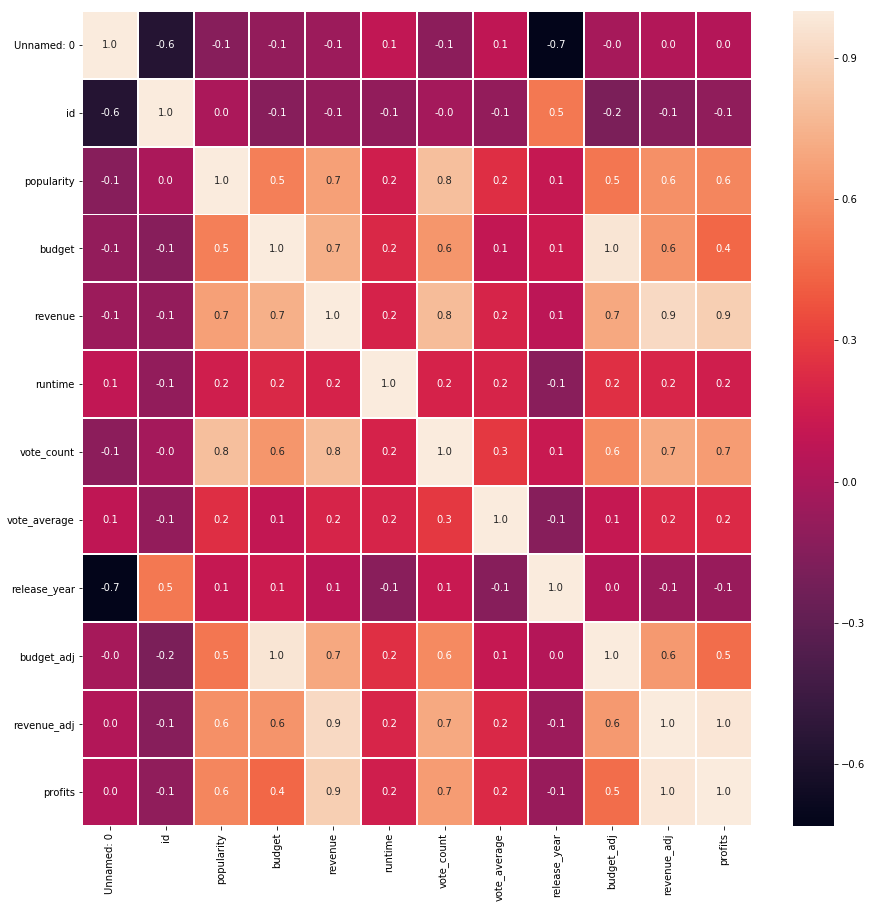

In [222]:
#correlation map
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_clean.corr(), annot=True, linewidths=1, fmt='.1f', ax=ax)
plt.show()

- The correlation factor between `popularity` and `revenue_adj` is 0.6;
- The correlation factor between `vote_average` and `revenue_adj` is 0.6.

In [232]:
# drop columns that are not related to revenue.
df_clean.drop(columns=['runtime', 'release_date', 'budget', 'revenue'], axis=1, inplace=True)
df_clean.head(1)

,Unnamed: 0,id,popularity,original_title,cast,director,genres,production_companies,vote_count,vote_average,release_year,budget_adj,revenue_adj,profits
0,0,135397,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09


#### Step 2.1: Analyze the correlation between <font color='red'>director</font> and <font color='red'>revenue</font> (`qualified` analysis).

In [413]:
# create a dictionary including all directors' names:
director_list = {}

for i in df_clean.director:
    for dir in i.split('|'):
        director_list[dir] = {'revenue': []}

In [414]:
# group the director's movie w.r.t to revenue and popularity
for i in df_clean.index:
    for dir in df_clean['director'].loc[i].split('|'):
        director_list[dir]['revenue'].append(df_clean['revenue_adj'].loc[i])

In [415]:
for i in director_list.keys():
    director_list[i]['revenue'] = round(sum(director_list[i]['revenue']),0)

- Find out the <font color='red'>top-10 directors</font> that have the high revenue.

In [416]:
list_revenue = {}

for i in director_list.keys():
    list_revenue[i] = director_list[i]['revenue']

In [417]:
# sort the revenue list.
sorted_list_revenue = sorted((v,k) for k,v in list_revenue.items())
sorted_list_revenue = sorted(sorted_list_revenue, reverse=True)[0:10]

list_revenue = {}

for i in sorted_list_revenue:
    list_revenue[i[1]] = i[0]

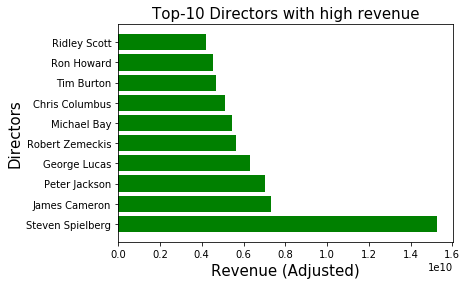

In [421]:
# visualize the rank of the top-10 directors
x = list_revenue.keys()
x_pos = [i for i, _ in enumerate(x)] # calculate the numerical value for each key.
y_pos = [i for i in list_revenue.values()]

plt.barh(x_pos, y_pos, color='green')
plt.ylabel("Directors", fontsize=15)
plt.xlabel("Revenue (Adjusted)", fontsize=15)
plt.title("Top-10 Directors with high revenue", fontsize=15)

plt.yticks(x_pos, x)

plt.show()

#### Step 2.2: Analyze the correlation between <font color='red'>casts</font> and <font color='red'>revenue</font> (`qualified` analysis)

In [425]:
# create a list including all casts' names:
cast_list = {}

for i in df_clean.cast:
    for cast in i.split('|'):
        cast_list[cast] = []

In [428]:
# group the director's movie w.r.t to revenue and popularity
for i in df_clean.index:
    for cast in df_clean['cast'].loc[i].split('|'):
        cast_list[cast].append(df_clean['revenue_adj'].loc[i])

In [430]:
for i in cast_list.keys():
    cast_list[i] = round(sum(cast_list[i]),0)

In [436]:
# sort the top-10 cast with high revenue:
sorted_list_revenue = sorted((v,k) for k,v in cast_list.items())
sorted_list_revenue = sorted(sorted_list_revenue, reverse=True)[0:10]

cast_list = {}

for i in sorted_list_revenue:
    cast_list[i[1]] = i[0]

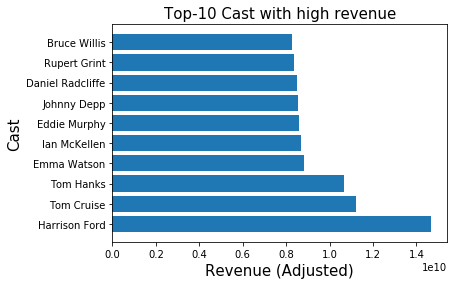

In [440]:
# visualize the correlation between revenue and casts:
x = cast_list.keys()
x_pos = [i for i, _ in enumerate(x)] # calculate the numerical value for each key.
y_pos = [i for i in cast_list.values()]

plt.barh(x_pos, y_pos)
plt.ylabel("Cast", fontsize=15)
plt.xlabel("Revenue (Adjusted)", fontsize=15)
plt.title("Top-10 Cast with high revenue", fontsize=15)

plt.yticks(x_pos, x)

plt.show()

<a id='conclusions'></a>
## Conclusions

### Which genres are most popular from year to year?

Based on the dataset, I found that three genres, i.e., Comedy, Thriller, and Drama, are very popular. 

### What kinds of properties are associated with movies that have high revenues?

To answer this question, I examed the dataset using two methods, i.e., quantitative method and qualitative method.

Based on the quantitative method, two metrics (popularity and vote_average) are highly related the revenue.
Based on the qualitative method, directors and casts are highly related to the revenue. 

To better understand the qualitative results, I found that Steven Spielberg is the most popular director who is related to the highest movie revenue. In addition, Harrison Ford is the most popular cast who is related to the highest revenue.